Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Aiman Lameesa"
ID = "st122876"

---

# Lab 12: Gaussian Mixture Models (GMMs)

In lecture, we learned that the Gaussian Mixture Model (GMM) is a more sophisticated unsupervised clustering method than
$k$-means.

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [2]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [3]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [4]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.18158254 0.212      0.60641746]
[0.2, 0.2, 0.6]
0.00010972791686499009


In [5]:
print(Mu)
print(np.array(means_gt).T)

[[ 9.83990103  0.98388193 10.0978809 ]
 [ 1.07767918 10.07702128  9.89991804]]
[[ 1 10 10]
 [10  1 10]]


In [6]:
print('Predicted Sigma:', Sigma)
print('Sigma_gt:', sigmas_gt)

Predicted Sigma: [[[ 3.48031612 -0.24552972]
  [-0.24552972  0.96079101]]

 [[ 0.89636225  0.08981256]
  [ 0.08981256  1.03557509]]

 [[ 0.99124757  0.1697637 ]
  [ 0.1697637   4.2521574 ]]]
Sigma_gt: [matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning
of the experiment. Report your results and briefly discuss in your lab report.

We can see that estimated values of Sigma, Mu, Phi are moderately close to the ground truth values set up at the beginning of the experiment. Though a few values are not close to the initial values, but most of them are close and easy to interpret. 

Next, we continue to find outliers:

In [7]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

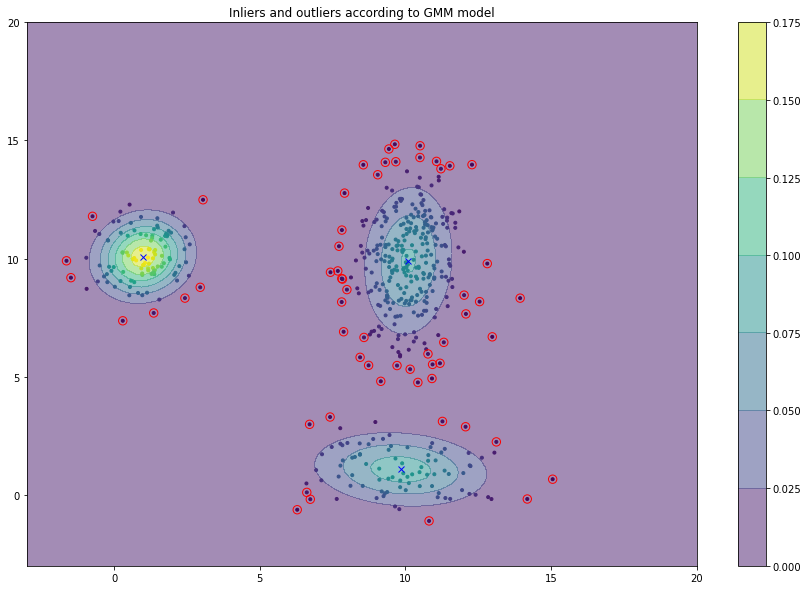

In [8]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, understand why, and explain in your report.  Second, read about Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain in your report. 

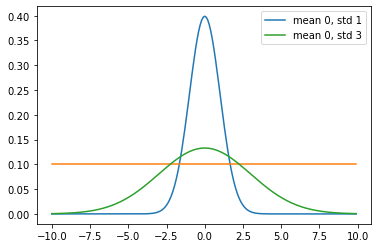

In [9]:
# You may need code to explain

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .1 steps.
x_axis = np.arange(-10, 10, 0.1)

thresh = np.full((200,), 0.1)
plt.plot(x_axis, norm.pdf(x_axis,0,1), label = 'mean 0, std 1') #mean 0, std 1
plt.plot(x_axis, thresh)
plt.plot(x_axis, norm.pdf(x_axis,0,3), label = 'mean 0, std 3') #mean 0, std 3

plt.legend()
plt.show()

YOUR ANSWER HERE

From the this plot, it can be observed that a broader cluster with a greater standard deviation contains more area apart from the threshold than a tight cluster. On the other hand, a tight cluster has a lower standard deviation and also contains less area apart from the hard threshold. This is why, a tight cluster has more inliers than a broad one and we get more outliers with a broad cluster than a tight one. 

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis (5 points)

YOUR ANSWER HERE

The Mahalanobis distance (MD) is the distance between a point and a distribution in a multivariate space. This distance is generally used to determine statistical analysis that contains a number of variables.

Euclidean distance only makes sense when all the dimensions or features have the same units since it involves adding the squared values of them. But we have to deal with features that have different units while making a prediction in machine learning. In these cases, the Mahalanobis distance transforms the random vector into a zero mean vector with an identity matrix for covariance. 

So, the steps for the Mahalanobis distance are:

1. Transforming the columns into uncorrelated variables
2. Scaling the columns so that their variance is equal to 1
3. Calculating the Euclidean distance at the end

The formula of Mahalanobis distance is:

$$ M.D(\vec{x}) = \sqrt{(\vec{x}-\vec{\mu})^{T} S^{-1} (\vec{x}-\vec{\mu})}$$ 

where $x$ is the vector of the observations, $\mu$ is the vector of mean values of independent variables and $S^{-1}$ is the inverse covariance matrix of the variables.

#### Write code Mahalanobis (10 points)

In [10]:
import sys
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1, 1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance, axis=1)), len(np.unique(np.argmin(m_distance, axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)
# YOUR CODE HERE
# raise NotImplementedError()

(3, 2, 2)
(2, 3)
(500, 2)


outlier (array([  4,  14,  16,  27,  41,  65,  76,  79,  84,  90,  92,  98, 102,
       105, 106, 110, 112, 122, 123, 125, 132, 133, 144, 163, 167, 176,
       177, 203, 224, 228, 240, 245, 248, 249, 264, 265, 275, 280, 284,
       300, 301, 305, 310, 314, 325, 331, 346, 348, 363, 368, 375, 389,
       391, 401, 410, 426, 436, 456, 463, 468, 470, 471, 474, 479, 484,
       490]),)


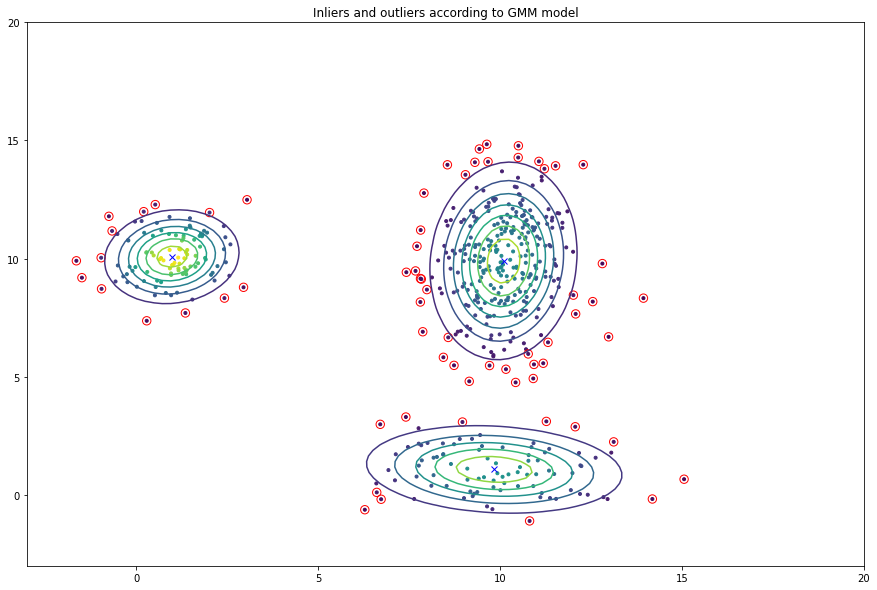

success!


In [11]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation
from last week dataset [Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

Let's stick to just two dimensions in the dataset:

In [12]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [19]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [20]:
print(Mu)

[[60.97109997 89.81940333 48.79547067]
 [55.95879041 14.95287927 56.22847905]]


The first row represents annual income, whereas the second row represents the spending score. From what i noticed, these values changes in every iteration, and therefore it is difficult segregate this data into 3 categories.

In [21]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

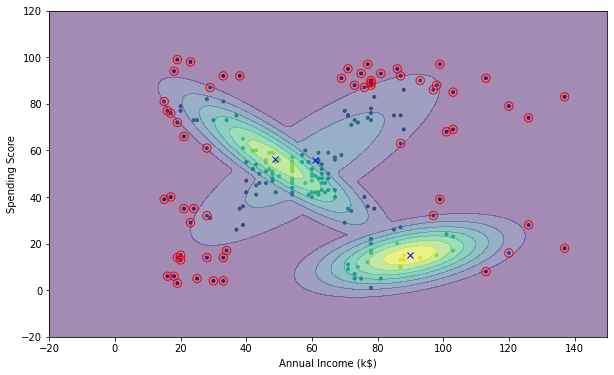

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to last week's results with k-means. (20 points)

#### Discussion report (5 points)

YOUR ANSWER HERE

In this plot, the x-axis is the Annual Income and the y-axis is the Spending Score. We can observe 3 different clusters here with some outliers. The clusters interpret:

1. A group of customers has high annual income but they spend very low, hence they have low spending score.
2. Another group of customers have low annual income but they spend more than the first group.
3. The last group of customers has moderate annual income with average spending score.  

The obtained groups of customers are slightly different from what we had in the K-means clustering. We had the same first two groups in K-means clustering result but the third group of customer used to have a very high income with a very high spending score comparing with the other two groups. This is the main difference of the obtained result here from the K-means clustering.

#### Do k-mean and compare the result

In [23]:
# YOUR CODE HERE
# raise NotImplementedError()

In [24]:
import random
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from IPython.display import clear_output
import time

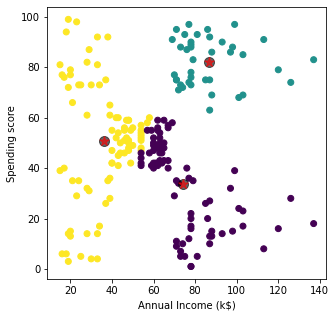

0.0


In [25]:
# 1. Initialize three random cluster centers
random.seed(400)
randomlist = random.sample(range(0, X.shape[0]),3) 
centers = X[randomlist]
means =  np.zeros((centers.shape)) 

while True:
    
    # 2. Find the nearest cluster center for each point
    labels = pairwise_distances_argmin(X, centers)
        
    # 4. Find the mean of the points assigned to each cluster center
    for i in range(centers.shape[0]):
        means[i] = np.mean(X[np.where(labels == i)],axis = 0)
        
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.scatter(centers[:, 0], centers[:, 1], s=100,marker = 'o', c="black", alpha=0.6)
    plt.scatter(means[:, 0], means[:, 1], s=100,marker = '*', c="red", alpha=0.6)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending score')
    plt.show()
    
    error = 0.0    
    for i in range(centers.shape[0]):
        error += ((means[i,:] - centers[i,:])**2).sum()
        
    print(error)
    if error < 1e-6:
        break
    else:
        centers = means 
    
    time.sleep(1)
    clear_output()

#raise NotImplementedError()

From this plot, we can compare the result of K-means from the GMM model. We have similar two groups of customers (1. high income but low spending score, 2. low income but high spending score) both in K-means and GMM model. But the third group of customer does not match. In K-means, the third group has a high annual income with a high spending score. On the other hand, the third group in GMM model has an average annual income with an average spending score.

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [26]:
outlier = 0.01
# YOUR CODE HERE

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1, 1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance, axis=1)), len(np.unique(np.argmin(m_distance, axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

# raise NotImplementedError()

outlier (array([  0,   4,   7,   8,  11,  17,  19,  30,  32,  33,  41, 127, 184,
       191, 192, 195, 196, 197, 198, 199]),)


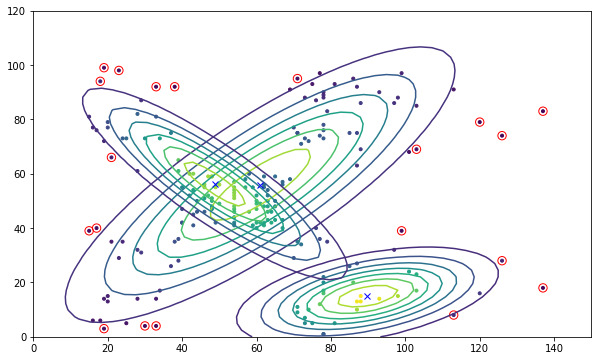

success!


In [27]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3 Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [3]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [4]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [5]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
UnitPrice,0,0.00
InvoiceDate,0,0.00
Quantity,0,0.00
StockCode,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [6]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [7]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [8]:
new_data = data.drop(['StockCode','InvoiceDate', 'Country'], axis = 1)

In [9]:
new_data

,Quantity,UnitPrice,TotalSum
0,6.0,2.55,15.30
1,6.0,3.39,20.34
2,8.0,2.75,22.00
3,6.0,3.39,20.34
4,6.0,3.39,20.34
...,...,...,...
4995,120.0,0.42,50.40
4996,120.0,0.42,50.40
4997,120.0,0.42,50.40
4998,48.0,0.55,26.40


In [10]:
Q1 = new_data.quantile(0.05) 
Q3 = new_data.quantile(0.85)  # 0.75 # 0.78

#we only take data within the Quartiles
new_data = new_data[~((data < (Q1)) |(new_data > (Q3))).any(axis=1)]

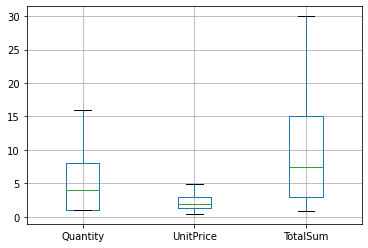

In [11]:
new_data.boxplot()

In [12]:
Mu = np.std(new_data[numerical_colmns])
Sigma = np.mean(new_data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     4.154745
UnitPrice    1.188172
TotalSum     7.479302
dtype: float64
Quantity     5.156735
UnitPrice    2.209901
TotalSum     9.648228
dtype: float64


In [13]:
# Check for outliers

def cnt_outlier(data, sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma**2
    return outlier.sum()

cnt_outlier(new_data, Sigma, Mu, numerical_colmns).sort_values(ascending=False)

TotalSum     0
UnitPrice    0
Quantity     0
dtype: int64

In [14]:
if len(new_data[new_data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(new_data[new_data.duplicated()]))
    print(new_data[new_data.duplicated(keep=False)].sort_values(by=list(new_data.columns)).head())
    new_data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  3047
     Quantity  UnitPrice  TotalSum
114       1.0       0.85      0.85
127       1.0       0.85      0.85
128       1.0       0.85      0.85
348       1.0       0.85      0.85
536       1.0       0.85      0.85


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [15]:
X = new_data.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[ 0.03199798  0.31868859  0.57931013]
 [ 0.03199798  0.98074657  1.2333532 ]
 [ 0.54105671  0.47632144  1.44877215]
 [ 0.03199798  1.65856783  1.90296873]
 [ 0.03199798 -0.23302639  0.03427423]
 [ 0.03199798 -0.03598533  0.22892991]
 [ 0.54105671  1.2644857   2.48693576]
 [ 0.03199798 -0.39065924 -0.12145031]
 [-0.73159012  2.21028281  0.52091342]
 [ 1.55917418 -1.02119065 -0.08251918]
 [ 0.03199798  2.21028281  2.44800463]
 [ 0.03199798 -0.85567616 -0.58083771]
 [-0.98611949  2.21028281 -0.12145031]
 [ 1.05011545 -0.15420997  1.12434602]
 [ 1.05011545  0.63395429  2.42205054]
 [ 1.05011545 -1.02119065 -0.30312894]
 [ 0.03199798  1.2644857   1.51365738]
 [ 1.05011545 -0.39065924  0.73503467]
 [ 0.03199798  0.63395429  0.89075921]
 [-0.22253139  2.21028281  1.80564089]
 [ 0.03199798 -0.70592495 -0.43289939]
 [-1.24064886 -0.70592495 -1.24396472]
 [-1.24064886 -1.02119065 -1.2958729 ]
 [-1.24064886  0.31868859 -1.07526313]
 [-0.73159012 -0.35913267 -0.74824159]
 [-1.24064886 -0.15420997

In [16]:
# Your code here

X[:10]

array([[ 0.03199798,  0.31868859,  0.57931013],
       [ 0.03199798,  0.98074657,  1.2333532 ],
       [ 0.54105671,  0.47632144,  1.44877215],
       [ 0.03199798,  1.65856783,  1.90296873],
       [ 0.03199798, -0.23302639,  0.03427423],
       [ 0.03199798, -0.03598533,  0.22892991],
       [ 0.54105671,  1.2644857 ,  2.48693576],
       [ 0.03199798, -0.39065924, -0.12145031],
       [-0.73159012,  2.21028281,  0.52091342],
       [ 1.55917418, -1.02119065, -0.08251918]])

In [17]:
X.shape

(175, 3)

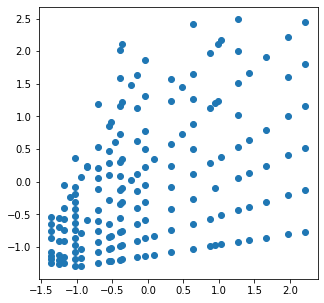

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 1], X[:, 2]) #qty and total sum
plt.show()

In [19]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p

In [20]:
# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [21]:
def Mahalanobis_distance(X, mean, covariance):
    X = X - mean.T
    ans = np.sqrt(np.sum(X @ np.linalg.inv(covariance) * X, axis=1))
    return ans

In [22]:
new_X = X[:, 1:]

In [23]:
new_X.shape

(175, 2)

In [24]:
k = 3
Phi, Mu, Sigma = init_gmm(new_X, k)
threshold = threshold = np.matrix(.1)
converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(new_X, threshold, Phi, Mu, Sigma)

In [25]:
outlier = 0.01

m_distance = np.zeros((new_X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(new_X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2
# find minimum distance
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

In [26]:
print(new_X.shape)

(175, 2)


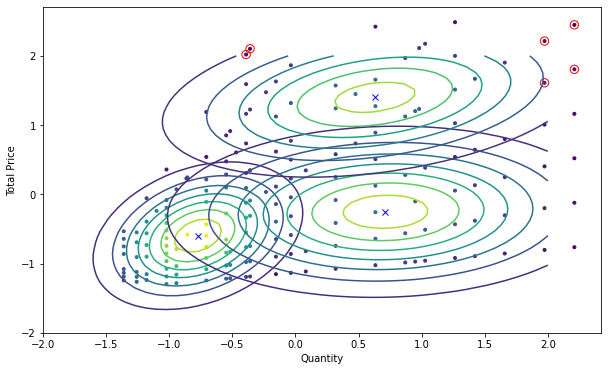

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(new_X[:,0], new_X[:,1], marker=".", c=pj, cmap='viridis');

plt.scatter(new_X[outlier,0], new_X[outlier,1], marker="o", facecolor="none", edgecolor="r", s=70);
plt.plot(Mu[0,0], Mu[1,0], 'bx', Mu[0,1], Mu[1,1], 'bx', Mu[0,2], Mu[1,2], 'bx')

for c in np.arange(0,k):    
    X_class = new_X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(-2, 2, 50)
    ylist = np.linspace(-2, 2, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:2,c], Sigma[c])
            j = j + 1
        i = i + 1    
        
    cp = plt.contour(XX, YY, Z)
    
plt.xlabel('Quantity')
plt.ylabel('Total Price')
plt.show()

In [39]:
def cost(X_label, Mu):
    loss = np.inf
    for j in range(Mu.shape[1]) : 
        Muj = Mu.T[j]
        Xj = X_label[X_label[:, -1] == j][:, :-1]
        loss = min(loss, np.min(np.linalg.norm(Xj-Muj)))
    return loss

In [43]:
likelihood = []

for k in range(1,4):
    
    threshold = np.matrix(.05)
    Phi, Mu, Sigma = init_gmm(new_X, k)
    converged = False
    
    while not converged:
        converged, pj, X_label = iterate_em_gmm(new_X, threshold, Phi, Mu, Sigma)
    loss = cost(X_label, Mu)
    likelihood.append(loss)

In [44]:
print(likelihood)

[18.708286933869708, 8.70252651101847, 5.258550108550214]


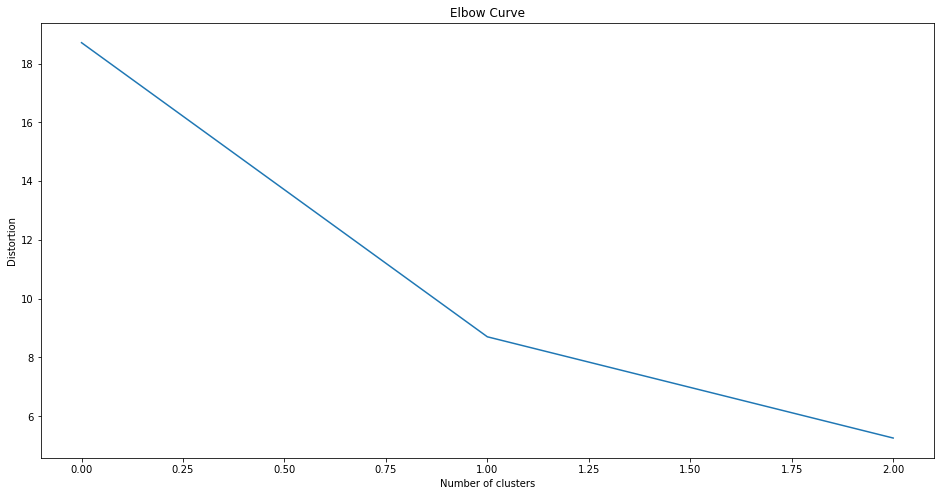

In [45]:
plt.figure(figsize=(16,8))
plt.plot(likelihood)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

The distortion seems to be optimum when the number of clusters is 2. The reason can be that the two clusters from the plot have a lot of similarities. If we have chosen k (the number of clusters) equals to 2, we can get 2 separate clusters that can be easily noticeable.

## Report

In lab exercise, we first generated some synthetic data from a mixture of Gaussians and then used Expectation Maximization (EM) to obtain the best possible ground truth parameters, which will enable the model to find the"anomalies". We also determine how close the estimated parmeters are to the ground truth values from the beginning. Then we observed that a broad cluster has more outliers than a tight cluster using a hard threshold. We studied about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and used Mahalanobis distance to get a better interpretation  of outliers for the dataset. 

Moreover, we used "Mall_Customers.csv" dataset from Kaggle and considered two dimensions (Annual Income and Spending Score) for customer segmentation. We interpretated the clusters we obtained from the figure. Then we run the K-means clustering with 3 clusters and compared the results. We also did the same analysis with Mahalanobis distanceon this dataset. 

After that, we used the "Online_Retail.csv" dataset for customer segmentation. We did preprocessing on the dataset and kept the Quantity, UnitPrice and TotalSum columns only. We checked the outliers and the duplicate entries for these columns. Then we applied the same Gaussian Mixture Model (GMM) on this dataset and tried to interpret the obtained results. Finally, we plotted likelihood as a function of  k (number of clusters) to see if there is an "elbow" in the plot and explained the result.